In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from code.classes import Order

## Load data

### Load orders

In [2]:
# Load data
with open('data/orders_history.json', 'r') as file:
    data = json.load(file)["orders"]

# Iterate through the orders and create instances of the Order class
orders = []
for order in data:
    items = order["items"]
    date = order["date"]
    order_instance = Order(*items, date=date)
    orders.append(order_instance)



In [3]:
# Show data
for order in orders[0:3]:
    print(f"Order id: {order.order_id}")
    print(f"Order date: {order.date}")
    print(f"Order: {order.items}")
    print(f"Order calories: {order.calories}")
    print(f"Order cost: {order.price}")
    print(f"Order accepted: {order.order_accepted}")
    print(f"Order refuse reason: {order.order_refused_reason}")
    print()

Order id: order--1
Order date: 2022-01-01
Order: ('meal-2', 'meal-6', 'meal-5')
Order calories: 995
Order cost: 14
Order accepted: True
Order refuse reason: None

Order id: order--2
Order date: 2022-01-01
Order: ('meal-5', 'combo-3', 'combo-3')
Order calories: 1140
Order cost: 23
Order accepted: True
Order refuse reason: None

Order id: order--3
Order date: 2022-01-01
Order: ('meal-3', 'combo-2', 'combo-1')
Order calories: None
Order cost: None
Order accepted: False
Order refuse reason: Too many calories! 2170 exceeds the limit of 2000.



### Make a DataFrame

In [4]:
# Create a list of dictionaries containing the attributes of each object
order_dicts = []
for order in orders:
    order_dict = {
        "order_id": order.order_id,
        "order_accepted": order.order_accepted,
        "order_refused_reason": order.order_refused_reason,
        "date": order.date,
        "items": order.items,
        "calories": order.calories,
        "price": order.price
    }
    order_dicts.append(order_dict)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(order_dicts)

# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

df.head(3)

,order_id,order_accepted,order_refused_reason,date,items,calories,price
0,order--1,True,None,2022-01-01,"(meal-2, meal-6, meal-5)",995.0,14.0
1,order--2,True,None,2022-01-01,"(meal-5, combo-3, combo-3)",1140.0,23.0
2,order--3,False,Too many calories! 2170 exceeds the limit of 2...,2022-01-01,"(meal-3, combo-2, combo-1)",NaN,NaN


In [5]:
# delete orders that were not accepted 
df.dropna(subset=['calories', 'price'], inplace=True)
df.head(3)

,order_id,order_accepted,order_refused_reason,date,items,calories,price
0,order--1,True,None,2022-01-01,"(meal-2, meal-6, meal-5)",995.0,14.0
1,order--2,True,None,2022-01-01,"(meal-5, combo-3, combo-3)",1140.0,23.0
3,order--4,True,None,2022-01-01,"(combo-1, combo-3)",1525.0,21.0


## Plots

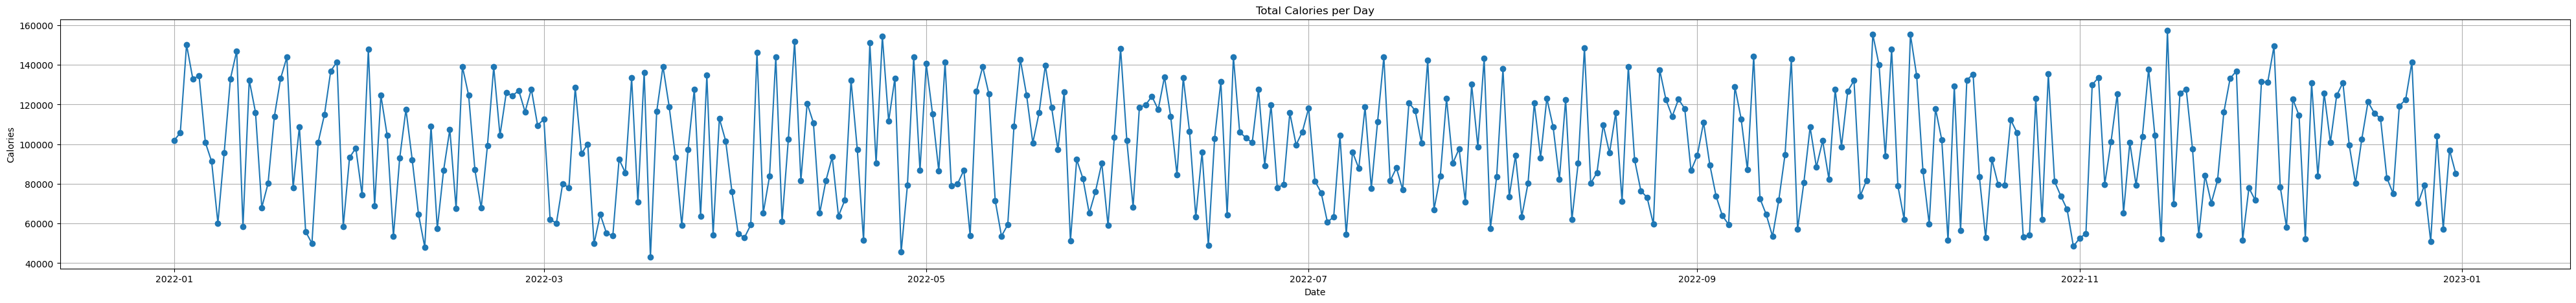

In [6]:
# Total calories per day

calories_per_day = df.groupby('date')['calories'].sum().reset_index()

plt.figure(figsize=(50, 5))
plt.plot(calories_per_day['date'],
         calories_per_day['calories'], 
         marker='o')
plt.title('Total Calories per Day')
plt.xlabel('Date')
plt.ylabel('Calories')
plt.grid(True)
plt.show()

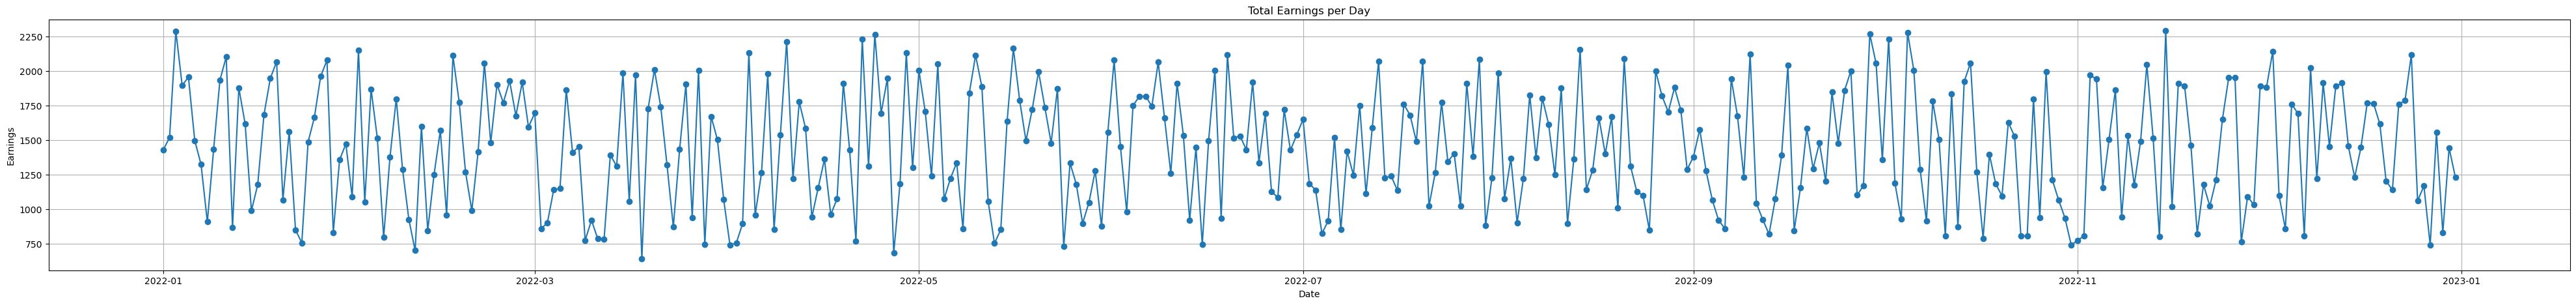

In [7]:
# Total earnings per day

earnings_per_day = df.groupby('date')['price'].sum().reset_index()

plt.figure(figsize=(50, 5))
plt.plot(earnings_per_day['date'],
         earnings_per_day['price'], 
         marker='o')
plt.title('Total Earnings per Day')
plt.xlabel('Date')
plt.ylabel('Earnings')
plt.grid(True)
plt.show()

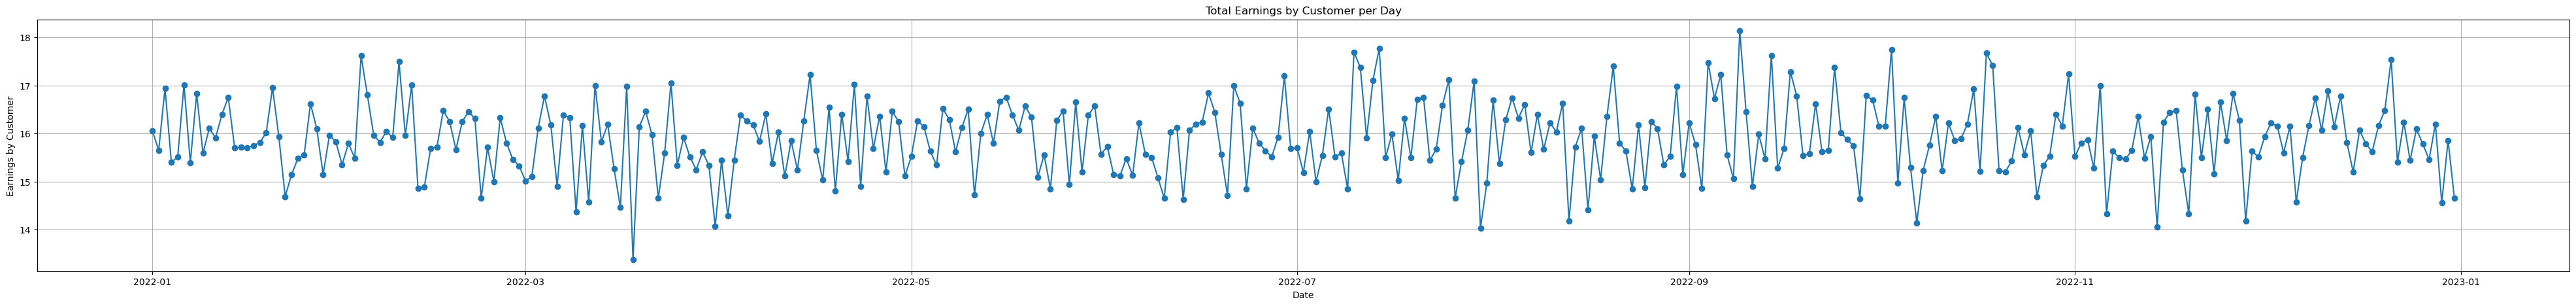

In [8]:
# Average earnings by customer served per day

earnings_per_day_by_customer = df.groupby('date')['price'].sum().reset_index()
earnings_per_day_by_customer['customer_number'] = df.groupby('date').size().values

plt.figure(figsize=(50, 5))
plt.plot(earnings_per_day_by_customer['date'],
         earnings_per_day_by_customer['price'] / earnings_per_day_by_customer['customer_number'], 
         marker='o')
plt.title('Total Earnings by Customer per Day')
plt.xlabel('Date')
plt.ylabel('Earnings by Customer')
plt.grid(True)
plt.show()

### Statistics

In [9]:
# a list of all items ordered
all_items = []
for item in df['items']:
    all_items.extend(item)

In [10]:


from code.constants import MEALS_DICT, COMBOS_DICT

df_all_items = pd.Series(all_items).value_counts().reset_index()
df_all_items.columns = ['ID', 'Frequency']
df_all_items['Earnings'] = [{**MEALS_DICT, **COMBOS_DICT}[item['ID']]['price'] * item['Frequency'] for index, item in df_all_items.iterrows()]
df_all_items['Name'] = [{**MEALS_DICT, **COMBOS_DICT}[item['ID']]['name'] for index, item in df_all_items.iterrows()]

df_all_items.head(3)

,ID,Frequency,Earnings,Name
0,combo-3,11869,118690,vegan combo
1,combo-2,11142,111420,veggie combo
2,combo-1,7410,81510,cheesy combo


In [11]:
# Most ordered meals
df_all_meals = df_all_items[df_all_items['ID'].str.contains('meal', case=False)]
most_common_meal = df_all_meals['Name'].mode().iloc[0]
print(f'The most ordered meal is: {most_common_meal}')

The most ordered meal is: cheese burger


In [12]:
# Most ordered combo
df_all_combos = df_all_items[df_all_items['ID'].str.contains('combo', case=False)]
most_common_combo = df_all_combos['Name'].mode().iloc[0]
print(f'The most ordered combo is: {most_common_combo}')

The most ordered combo is: cheesy combo


In [13]:
# Combo or meal that brought the most money
item_most_earning = df_all_items.loc[df_all_items['Earnings'].idxmax()][['Name']].iloc[0]
print(f'The most earnings came from: {item_most_earning}')

The most earnings came from: vegan combo
